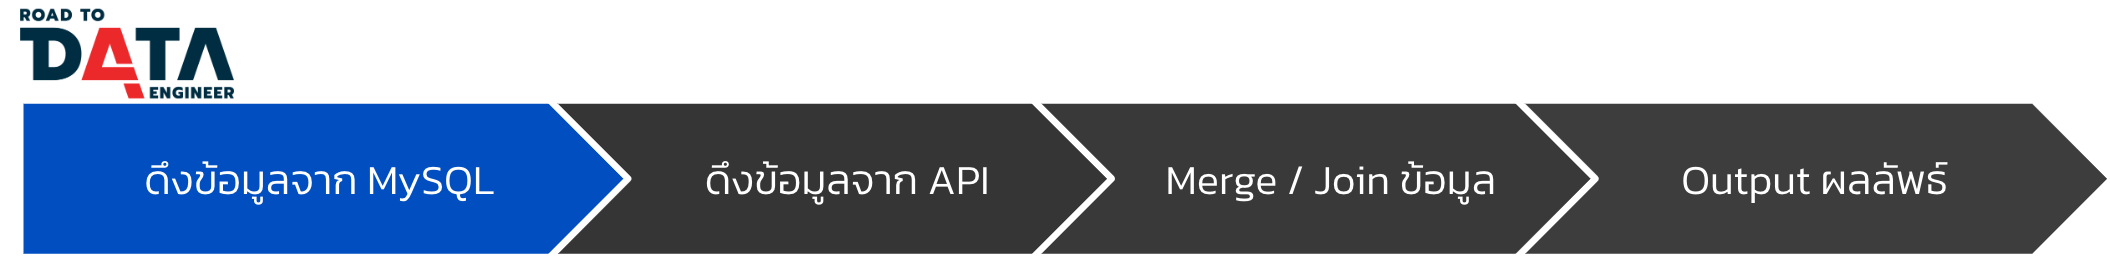

# Step 1) อ่านข้อมูลจาก MySQL database

## Install PyMySQL
ซึ่งเป็น package สำหรับเชื่อมต่อ MySQL database ใน workshop นี้เราจะใช้ Sqlalchemy (มี install ไว้อยู่แล้วใน Colab) ควบคู่กับ PyMySQL driver เพื่อใช้งาน MySQL

In [ ]:
! pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.9 MB/s eta 0:00:00


ขั้นตอนแรกสำหรับการต่อ database คือการสร้าง connection ซึ่งต้องอาศัย config ต่าง ๆ เช่น Host (IP address), Username, Password ในการเชื่อมต่อ เป็นต้น บางอย่างก็ต้องเก็บเป็นความลับ

### ใส่ Colab Secrets

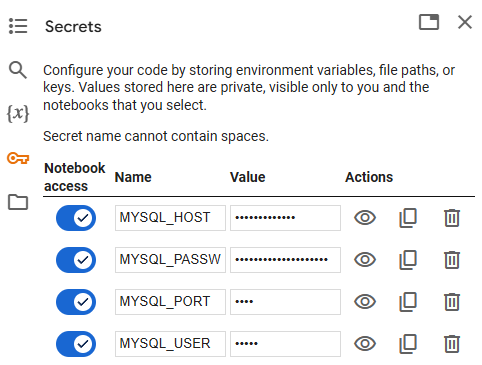

In [ ]:
# import function ให้สามารถใช้ค่าจาก Colab Secret
from google.colab import userdata

# เราจะใช้ userdata.get("key") เพื่อเข้าถึง Colab Secrets
class Config:
  MYSQL_HOST = userdata.get("MYSQL_HOST")
  MYSQL_PORT = userdata.get("MYSQL_PORT")  # default port ของ MySQL คือ 3306
  MYSQL_USER = userdata.get("MYSQL_USER")
  MYSQL_PASSWORD = userdata.get("MYSQL_PASSWORD")
  MYSQL_DB = 'r2de3'
  MYSQL_CHARSET = 'utf8mb4'

## Connect to DB
หลังจากที่มี Credential ของ database แล้วก็สร้าง connection โดยการ connect ไปที่ DB ด้วย Config ของเรา

In [ ]:
import sqlalchemy

engine = sqlalchemy.create_engine(
    "mysql+pymysql://{user}:{password}@{host}:{port}/{db}".format(
        user=Config.MYSQL_USER,
        password=Config.MYSQL_PASSWORD,
        host=Config.MYSQL_HOST,
        port=Config.MYSQL_PORT,
        db=Config.MYSQL_DB,
    )
)

**engine** เป็น object ของ database ที่เอาไว้ใช้ในการเข้าถึง data การใช้งานจึงเป็นไปตามการออกแบบของแต่ละ database  ในกรณีนี้ก็จะใช้อ้างอิงตาม documentation

ตัวแปร engine นี้ เราได้ connect ต่อเข้ากับ database เอาไว้แล้ว
## Show Tables
เรามาลองดูกันว่ามี table อะไรในนั้นบ้าง

In [ ]:
# list all tables ด้วย SQL คำสั่ง show tables;

with engine.connect() as connection:
    result = connection.execute(sqlalchemy.text(f"show tables;")).fetchall()

result

[('customer',), ('product',), ('transaction',)]

## Info: Table และ Schema ของข้อมูล
**Tables**:

*   **r2de3.transaction** - ข้อมูลการขายสินค้า
*   **r2de3.customer** - ข้อมูลลูกค้า
*   **r2de3.product** - ข้อมูลสินค้าแต่ละชิ้น

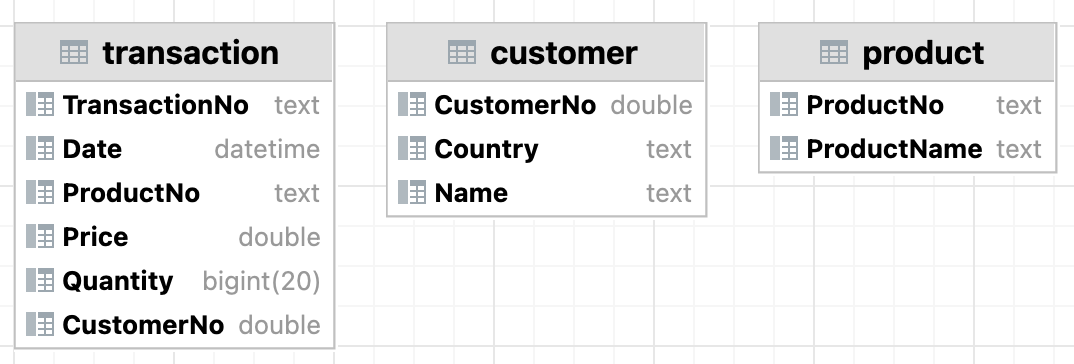

## Query Table (วิธีที่ 1: sqlalchemy)

### เขียน Query เพื่อ Select ข้อมูลจากตาราง r2de3.product

In [ ]:
with engine.connect() as connection:
  product_result = connection.execute(sqlalchemy.text(f"select * from product")).fetchall()

## Convert data to Pandas

In [ ]:
import pandas as pd

In [ ]:
product = pd.DataFrame(product_result)

In [ ]:
product

,ProductNo,ProductName
0,22485,Set Of 2 Wooden Market Crates
1,22596,Christmas Star Wish List Chalkboard
2,23235,Storage Tin Vintage Leaf
3,23272,Tree T-Light Holder Willie Winkie
4,23239,Set Of 4 Knick Knack Tins Poppies
...,...,...
3763,22275,Weekend Bag Vintage Rose Paisley
3764,16161M,Wrap Pink Flock
3765,84854,Girly Pink Tool Set
3766,82615,Pink Marshmallow Scarf Knitting Kit


## Query Table (วิธีที่ 2: Pandas) -- สะดวกกว่า

### เขียน Query เพื่อ Select ข้อมูลจากตาราง r2de3.customer

In [ ]:
customer = pd.read_sql("SELECT * FROM r2de3.customer", engine)
customer

,CustomerNo,Country,Name
0,17490.0,United Kingdom,Sara Griffin
1,13069.0,United Kingdom,Michael Holt
2,12433.0,Norway,Kelli Sandoval
3,13426.0,United Kingdom,Dalton Graves
4,17364.0,United Kingdom,Michelle James
...,...,...,...
4734,16274.0,United Kingdom,Megan Young
4735,14142.0,United Kingdom,Luke Williams
4736,13065.0,United Kingdom,Lisa Jones
4737,18011.0,United Kingdom,Kelly Jenkins


### เขียน Query เพื่อ Select ข้อมูลจากตาราง r2de3.transaction

In [ ]:
transaction = pd.read_sql("SELECT * FROM r2de3.transaction", engine)
transaction

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo
0,581482,2024-05-10,22485,21.47,12,17490.0
1,581475,2024-05-10,22596,10.65,36,13069.0
2,581475,2024-05-10,23235,11.53,12,13069.0
3,581475,2024-05-10,23272,10.65,12,13069.0
4,581475,2024-05-10,23239,11.94,6,13069.0
...,...,...,...,...,...,...
536345,C536548,2023-05-03,22168,18.96,-2,12472.0
536346,C536548,2023-05-03,21218,14.09,-3,12472.0
536347,C536548,2023-05-03,20957,11.74,-1,12472.0
536348,C536548,2023-05-03,22580,16.35,-4,12472.0


ตอนนี้เราได้ข้อมูล `product`, `customer`, และ `transaction` เป็น dataframe ครบแล้ว

## Join tables: product & customer & transaction

ใน transaction dataframe เราจะไม่เห็นชื่อสินค้า และชื่อลูกค้า ถ้าเราอยากรู้ว่าแต่ละ transaction เป็นสินค้าอะไร และใครซื้อ ต้อง merge table เข้าด้วยกัน

คีย์ที่ใช้ในการ merge คือ
- transaction: `ProductNo`, `CustomerNo`
- product: `ProductNo`
- customer: `CustomerNo`

In [ ]:
merged_transaction = transaction.merge(product, how="left", left_on="ProductNo", right_on="ProductNo").merge(customer, how="left", left_on="CustomerNo", right_on="CustomerNo")

ผลลัพธ์จากการ join จะได้เป็นแบบนี้

In [ ]:
merged_transaction

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo,ProductName,Country,Name
0,581482,2024-05-10,22485,21.47,12,17490.0,Set Of 2 Wooden Market Crates,United Kingdom,Sara Griffin
1,581475,2024-05-10,22596,10.65,36,13069.0,Christmas Star Wish List Chalkboard,United Kingdom,Michael Holt
2,581475,2024-05-10,23235,11.53,12,13069.0,Storage Tin Vintage Leaf,United Kingdom,Michael Holt
3,581475,2024-05-10,23272,10.65,12,13069.0,Tree T-Light Holder Willie Winkie,United Kingdom,Michael Holt
4,581475,2024-05-10,23239,11.94,6,13069.0,Set Of 4 Knick Knack Tins Poppies,United Kingdom,Michael Holt
...,...,...,...,...,...,...,...,...,...
536345,C536548,2023-05-03,22168,18.96,-2,12472.0,Organiser Wood Antique White,Germany,Stephen Pena
536346,C536548,2023-05-03,21218,14.09,-3,12472.0,Red Spotty Biscuit Tin,Germany,Stephen Pena
536347,C536548,2023-05-03,20957,11.74,-1,12472.0,Porcelain Hanging Bell Small,Germany,Stephen Pena
536348,C536548,2023-05-03,22580,16.35,-4,12472.0,Advent Calendar Gingham Sack,Germany,Stephen Pena


ตอนนี้เราได้ข้อมูล transaction มาแล้ว แต่ว่าข้อมูล price มีหน่วยเป็น GBP

ในส่วนถัดไป เราจะมาอ่าน data จาก API แปลงค่าเงิน เพื่อแปลงเป็นเงินบาท ตาม rate ของแต่ละวันในอดีตกัน

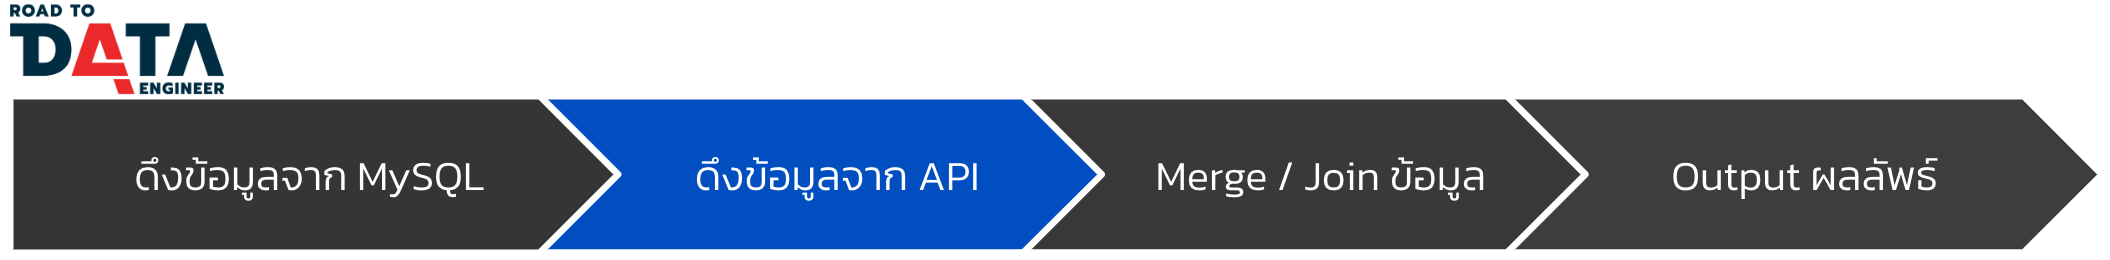

# Step 2) ดึงข้อมูลการแปลงค่าเงินจาก API ด้วย Requests

Package `requests` ใช้สำหรับการเรียกใช้ REST API

(โดยปกติต้อง install package นี้เพิ่มเติม แต่ colab มี install ไว้อยู่แล้ว)

วิธีการ install: `pip install requests`

In [ ]:
import requests

### Call API (HTTP GET) สำหรับ conversion rate

In [ ]:
url = "https://r2de3-currency-api-vmftiryt6q-as.a.run.app/gbp_thb"

# ใช้ package requests ยิง API
r = requests.get(url)
result_conversion_rate = r.json()

In [ ]:
result_conversion_rate

[{'date': '2023-05-01', 'gbp_thb': 42.761, 'id': '5e41'},
 {'date': '2023-05-02', 'gbp_thb': 42.477, 'id': 'bd18'},
 {'date': '2023-05-03', 'gbp_thb': 42.63, 'id': '658e'},
 {'date': '2023-05-04', 'gbp_thb': 42.456, 'id': '10f7'},
 {'date': '2023-05-05', 'gbp_thb': 42.794, 'id': 'a76a'},
 {'date': '2023-05-06', 'gbp_thb': 42.794, 'id': 'dcba'},
 {'date': '2023-05-07', 'gbp_thb': 42.794, 'id': '9e56'},
 {'date': '2023-05-08', 'gbp_thb': 42.746, 'id': '4257'},
 {'date': '2023-05-09', 'gbp_thb': 42.539, 'id': 'f7bf'},
 {'date': '2023-05-10', 'gbp_thb': 42.48, 'id': 'f0ed'},
 {'date': '2023-05-11', 'gbp_thb': 42.309, 'id': '99bd'},
 {'date': '2023-05-12', 'gbp_thb': 42.267, 'id': 'a94c'},
 {'date': '2023-05-13', 'gbp_thb': 42.267, 'id': '7ddc'},
 {'date': '2023-05-14', 'gbp_thb': 42.267, 'id': '242f'},
 {'date': '2023-05-15', 'gbp_thb': 42.329, 'id': 'a5b7'},
 {'date': '2023-05-16', 'gbp_thb': 42.574, 'id': '1fea'},
 {'date': '2023-05-17', 'gbp_thb': 42.752, 'id': 'bc0f'},
 {'date': '2023-

 ## Convert to Pandas

In [ ]:
conversion_rate = pd.DataFrame(result_conversion_rate)

In [ ]:
conversion_rate

,date,gbp_thb,id
0,2023-05-01,42.761,5e41
1,2023-05-02,42.477,bd18
2,2023-05-03,42.630,658e
3,2023-05-04,42.456,10f7
4,2023-05-05,42.794,a76a
...,...,...,...
384,2024-05-19,45.957,f892
385,2024-05-20,45.859,63b8
386,2024-05-21,46.246,1727
387,2024-05-22,46.382,2d4f


Drop (ลบ) column `id` ที่ไม่ได้ใช้



In [ ]:
conversion_rate = conversion_rate.drop(columns=['id'])

In [ ]:
conversion_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     389 non-null    object 
 1   gbp_thb  389 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.2+ KB


In [ ]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536350 non-null  object        
 1   Date           536350 non-null  datetime64[ns]
 2   ProductNo      536350 non-null  object        
 3   Price          536350 non-null  float64       
 4   Quantity       536350 non-null  int64         
 5   CustomerNo     536295 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 24.6+ MB


เปลี่ยนประเภทของ column `date` จาก string ที่อ่านมาได้จาก API ให้เป็นประเภท `dt.date` ให้เหมือนกับใน `merged_transaction`

In [ ]:
conversion_rate['date'] = pd.to_datetime(conversion_rate['date'])
conversion_rate.head()

,date,gbp_thb
0,2023-05-01,42.761
1,2023-05-02,42.477
2,2023-05-03,42.630
3,2023-05-04,42.456
4,2023-05-05,42.794


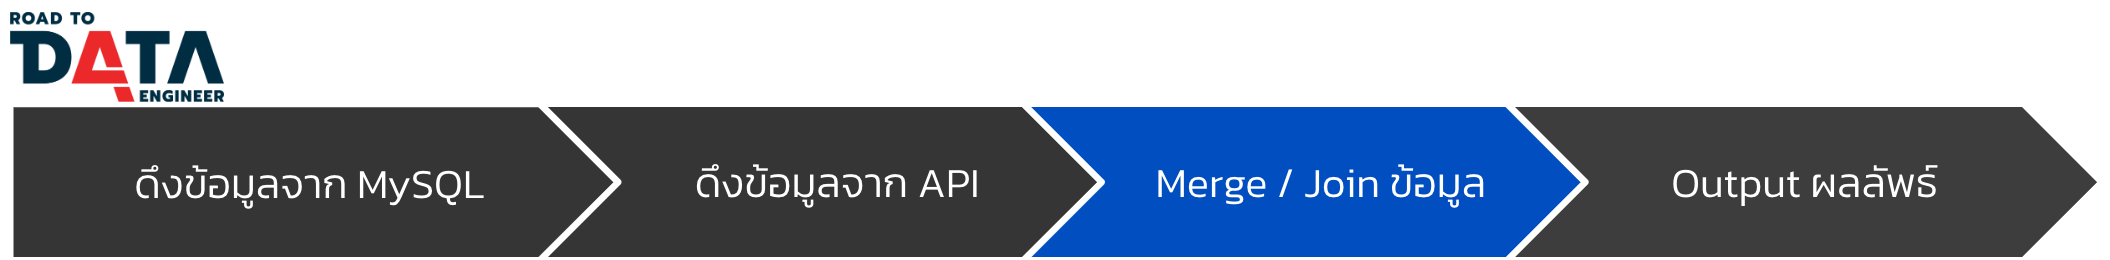

# Step 3) Join the data

ในตอนนี้เราจะนำข้อมูลการซื้อขายและข้อมูล Rate การแปลงค่าเงิน เราจะรวมข้อมูลจากทั้งสอง Dataframe มารวมกัน

เราจะนำข้อมูลจากทั้งสองมารวมกันผ่าน column date ใน transaction และ date ใน conversion_rate

## สร้าง `finalDF` ที่เกิดจากการ merge DataFrame `merged_transaction` เข้ากับ `conversion_rate`

In [ ]:
final_df = merged_transaction.merge(conversion_rate, how="left", left_on="Date", right_on="date")
final_df

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo,ProductName,Country,Name,date,gbp_thb
0,581482,2024-05-10,22485,21.47,12,17490.0,Set Of 2 Wooden Market Crates,United Kingdom,Sara Griffin,2024-05-10,45.77
1,581475,2024-05-10,22596,10.65,36,13069.0,Christmas Star Wish List Chalkboard,United Kingdom,Michael Holt,2024-05-10,45.77
2,581475,2024-05-10,23235,11.53,12,13069.0,Storage Tin Vintage Leaf,United Kingdom,Michael Holt,2024-05-10,45.77
3,581475,2024-05-10,23272,10.65,12,13069.0,Tree T-Light Holder Willie Winkie,United Kingdom,Michael Holt,2024-05-10,45.77
4,581475,2024-05-10,23239,11.94,6,13069.0,Set Of 4 Knick Knack Tins Poppies,United Kingdom,Michael Holt,2024-05-10,45.77
...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2023-05-03,22168,18.96,-2,12472.0,Organiser Wood Antique White,Germany,Stephen Pena,2023-05-03,42.63
536346,C536548,2023-05-03,21218,14.09,-3,12472.0,Red Spotty Biscuit Tin,Germany,Stephen Pena,2023-05-03,42.63
536347,C536548,2023-05-03,20957,11.74,-1,12472.0,Porcelain Hanging Bell Small,Germany,Stephen Pena,2023-05-03,42.63
536348,C536548,2023-05-03,22580,16.35,-4,12472.0,Advent Calendar Gingham Sack,Germany,Stephen Pena,2023-05-03,42.63


ตอนนี้เรามี column `Price` และ `Quantity` แต่ยังไม่มี total amount ซึ่งเกิดจากการคูณกันของ `Price * Quantity`

In [ ]:
final_df["total_amount"] = final_df["Price"] * final_df["Quantity"]
final_df.head()

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo,ProductName,Country,Name,date,gbp_thb,total_amount
0,581482,2024-05-10,22485,21.47,12,17490.0,Set Of 2 Wooden Market Crates,United Kingdom,Sara Griffin,2024-05-10,45.77,257.64
1,581475,2024-05-10,22596,10.65,36,13069.0,Christmas Star Wish List Chalkboard,United Kingdom,Michael Holt,2024-05-10,45.77,383.40
2,581475,2024-05-10,23235,11.53,12,13069.0,Storage Tin Vintage Leaf,United Kingdom,Michael Holt,2024-05-10,45.77,138.36
3,581475,2024-05-10,23272,10.65,12,13069.0,Tree T-Light Holder Willie Winkie,United Kingdom,Michael Holt,2024-05-10,45.77,127.80
4,581475,2024-05-10,23239,11.94,6,13069.0,Set Of 4 Knick Knack Tins Poppies,United Kingdom,Michael Holt,2024-05-10,45.77,71.64


## เพิ่ม column `thb_amount` ที่เกิดจากการคูณกันของ `total_amount` กับ `gbp_thb`

In [ ]:
final_df["thb_amount"] = final_df["total_amount"]*final_df["gbp_thb"]
final_df

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo,ProductName,Country,Name,date,gbp_thb,total_amount,thb_amount
0,581482,2024-05-10,22485,21.47,12,17490.0,Set Of 2 Wooden Market Crates,United Kingdom,Sara Griffin,2024-05-10,45.77,257.64,11792.1828
1,581475,2024-05-10,22596,10.65,36,13069.0,Christmas Star Wish List Chalkboard,United Kingdom,Michael Holt,2024-05-10,45.77,383.40,17548.2180
2,581475,2024-05-10,23235,11.53,12,13069.0,Storage Tin Vintage Leaf,United Kingdom,Michael Holt,2024-05-10,45.77,138.36,6332.7372
3,581475,2024-05-10,23272,10.65,12,13069.0,Tree T-Light Holder Willie Winkie,United Kingdom,Michael Holt,2024-05-10,45.77,127.80,5849.4060
4,581475,2024-05-10,23239,11.94,6,13069.0,Set Of 4 Knick Knack Tins Poppies,United Kingdom,Michael Holt,2024-05-10,45.77,71.64,3278.9628
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2023-05-03,22168,18.96,-2,12472.0,Organiser Wood Antique White,Germany,Stephen Pena,2023-05-03,42.63,-37.92,-1616.5296
536346,C536548,2023-05-03,21218,14.09,-3,12472.0,Red Spotty Biscuit Tin,Germany,Stephen Pena,2023-05-03,42.63,-42.27,-1801.9701
536347,C536548,2023-05-03,20957,11.74,-1,12472.0,Porcelain Hanging Bell Small,Germany,Stephen Pena,2023-05-03,42.63,-11.74,-500.4762
536348,C536548,2023-05-03,22580,16.35,-4,12472.0,Advent Calendar Gingham Sack,Germany,Stephen Pena,2023-05-03,42.63,-65.40,-2788.0020


## ลบ Column ที่ไม่ใช้ และเปลี่ยนชื่อ Column

In [ ]:
final_df = final_df.drop(["date", "gbp_thb"], axis=1)

List ชื่อ column ทั้งหมด

In [ ]:
final_df.columns

Index(['TransactionNo', 'Date', 'ProductNo', 'Price', 'Quantity', 'CustomerNo',
       'ProductName', 'Country', 'Name', 'total_amount', 'thb_amount'],
      dtype='object')

เปลี่ยนชื่อ column ให้เป็นตัวพิมพ์เล็ก และเปลี่ยนชื่อ column ที่ลงท้ายด้วย `No` ให้เป็น `_id`
- TransactionNo → transaction_id
- Date → date
- ProductNo → product_id
- Price → price
- Quantity → quantity
- CustomerNo → customer_id
- ProductName → product_name
- Country → customer_country
- Name → customer_name
- total_amount → total_amount (unchange)
- thb_amount → thb_amount (unchange)

In [ ]:
final_df.columns = ['transaction_id', 'date', 'product_id', 'price', 'quantity', 'customer_id',
       'product_name', 'customer_country', 'customer_name', 'total_amount','thb_amount']

In [ ]:
final_df

,transaction_id,date,product_id,price,quantity,customer_id,product_name,customer_country,customer_name,total_amount,thb_amount
0,581482,2024-05-10,22485,21.47,12,17490.0,Set Of 2 Wooden Market Crates,United Kingdom,Sara Griffin,257.64,11792.1828
1,581475,2024-05-10,22596,10.65,36,13069.0,Christmas Star Wish List Chalkboard,United Kingdom,Michael Holt,383.40,17548.2180
2,581475,2024-05-10,23235,11.53,12,13069.0,Storage Tin Vintage Leaf,United Kingdom,Michael Holt,138.36,6332.7372
3,581475,2024-05-10,23272,10.65,12,13069.0,Tree T-Light Holder Willie Winkie,United Kingdom,Michael Holt,127.80,5849.4060
4,581475,2024-05-10,23239,11.94,6,13069.0,Set Of 4 Knick Knack Tins Poppies,United Kingdom,Michael Holt,71.64,3278.9628
...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2023-05-03,22168,18.96,-2,12472.0,Organiser Wood Antique White,Germany,Stephen Pena,-37.92,-1616.5296
536346,C536548,2023-05-03,21218,14.09,-3,12472.0,Red Spotty Biscuit Tin,Germany,Stephen Pena,-42.27,-1801.9701
536347,C536548,2023-05-03,20957,11.74,-1,12472.0,Porcelain Hanging Bell Small,Germany,Stephen Pena,-11.74,-500.4762
536348,C536548,2023-05-03,22580,16.35,-4,12472.0,Advent Calendar Gingham Sack,Germany,Stephen Pena,-65.40,-2788.0020


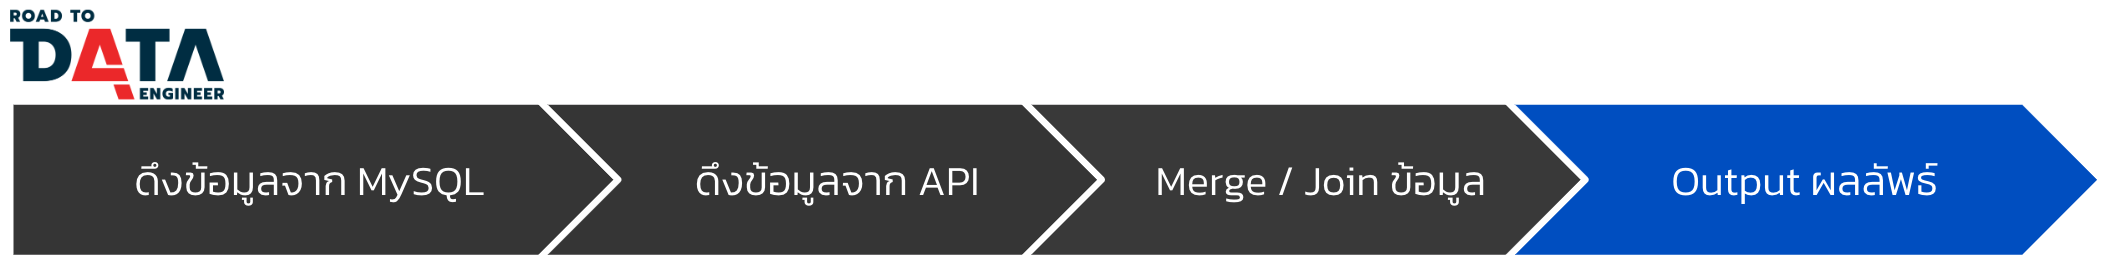

# Step 4) Output ไฟล์ผลลัพธ์

In [ ]:
final_df.to_parquet("output.parquet", index=False)